In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

kNN 알고리즘은 주변의 가까운 이웃들에게 물어봐서 대다수의 답변과 동일하게 답변하는 방법이다. 만약에 3명에게 물어봤는데 2명이 거짓으로 대답을 한다면 예측은 틀리게 된다. kNN은 '지금 현재 이곳이 강남인가요? 강북인가요?'와 같이 질문을 한다면 SVM은 '지금 현재 이곳이 한강의 남쪽인가요? 북쪽인가요?'와 같이 질문해서 답변을 얻는 방식이다.

서포트 벡터라는 개념은 한강의 위치를 찾는데 사용되는 개념으로 한강은 현재 위치가 강북인지 강남인지 구분하는 결정 경계선(decision boundary)이다. 서포트 벡터는 결정 경계선을 찾는데 사용되는 개념이고 벡터는 2차원 공간상에 나타나는 데이터 포인트를 의미한다. 따라서 서포트 벡터는 결정 경계선과 가장 가까이 맞닿은 데이터 포인트를 의미한다.

서포트 벡터와 결정 경계선 사이의 거리를 마진이라 하고 서포트 벡터 머신의 목표는 마진을 최대로 하는 결정 경계를 찾는 것이다.  
서포트 벡터 머신에서 약간의 오차를 허용하기 위해 비용(C)이라는 변수를 사용한다. 비용이 낮을(오차가 작을)수록 마진을 최대한 높이고 학습 에러율은 증가하는 방향으로 결정 경계선을 만들고 비용이 높을(오차가 클) 수록 마진은 최대한 낮추고 학습 에러율은 감소하는 방향으로 결정 경계를 만든다. 비용이 너무 낮으면 과대 적합의 위험이 있으니 적절한 비용값을 찾는 과정이 상당히 중요하다.

데이터 획득

In [2]:
df = pd.read_csv('./data/basketball_stat.csv')
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
train, test = train_test_split(df, train_size=0.8)
df.head()

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5


커널 트릭(kernel trick)

저차원 벡터 공간의 데이터를 고차원 벡터 공간으로 옮겨줌으로써 결정 경계를 찾는 방법이 있다.  
저차원의 데이터를 고차원의 데이터로 옮겨주는 함수를 매핑 함수라 하고 매핑 함수를 가지고 많은 양의 데이터를 저차원에서 고차원으로 옮기기에는 계산량이 너무 많아져서 현실적으로는 사용하기 어렵다. 실제로 데이터를 고차원으로 보내지는 않지만 보낸 것과 동일한 효과를 줘서 빠른 속도로 결정 경계를 찾는 방밥이 고안되었으며 이를 커널 트릭이라 한다.

최적의 SVM 파라미터 찾기

SVM 알고리즘은 RBF(가우시안) 커널을 사용하므로 마진이 너비를 조정하는 파라미터(C)와 결정 경계선의 곡률을 조정하는 파라미터(gamma)를 알아야 한다.  
사이킷런의 그리드 서치(grid search)를 개발자가 부여한 비용과 감마의 후보들을 조합해서 최적의 비용과 감마값을 알아낸다.

In [3]:
# 최적의 비용과 감마값을 알아내기 위해 import 한다.
from sklearn.model_selection import GridSearchCV
# SVM 알고리즘을 사용하기 위해 import 한다. SVC => Support Vector Classification
from sklearn.svm import SVC

In [4]:
# 사이킷런에서 제공하는 GridSearchCV를 사용해서 최적의 비용과 감마값을 가지는 SVM 객체를 리턴하는 함수
def svm_param_selection(x, y, nfold):
    # 비용과 감마값의 후보를 임의로 정한다.
    svm_params = [{
        'kernel': ['rbf'],
        'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
        'C': [0.01, 0.1, 1, 10, 100, 1000]
    }]
    clf = GridSearchCV(SVC(), svm_params, cv=nfold) # GridSearchCV 객체를 만든다.
    clf.fit(x, y.values.ravel()) # GridSearchCV 객체를 학습시킨다.
    return clf

In [5]:
x_train = train[['3P', 'BLK']] # 3점슛과 블로킹 횟수를 피쳐로 지정한다.
y_train = train['Pos'] # 포지션을 타겟으로 지정한다.
clf = svm_param_selection(x_train, y_train, 10)
print('최고 점수: {}'.format(clf.best_score_))
print('최고 점수를 낸 파라미터: {}, C: {}, gamma: {}'.format(clf.best_params_, clf.best_params_['C'], clf.best_params_['gamma']))
print('최고 점수를 낸 파라미터를 가진 SVM 모델: {}'.format(clf.best_estimator_))

최고 점수: 0.975
최고 점수를 낸 파라미터: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}, C: 0.1, gamma: 1
최고 점수를 낸 파라미터를 가진 SVM 모델: SVC(C=0.1, gamma=1)


결정 경계 시각화

In [6]:
# 최고 점수를 낸 파라미터를 이용해서 시각화 할 비용(C)의 후보들을 저장한다.
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C']) # 최적의 'C'값
C_canditates.append(clf.best_params_['C'] * 100)
print(C_canditates)

# 최고 점수를 낸 파라미터를 이용해서 시각화 할 gamma의 후보들을 저장한다.
gamma_canditates = []
gamma_canditates.append(clf.best_params_['gamma'] * 0.01)
gamma_canditates.append(clf.best_params_['gamma']) # 최적의 'gamma'값
gamma_canditates.append(clf.best_params_['gamma'] * 100)
print(gamma_canditates)

[0.001, 0.1, 10.0]
[0.01, 1, 100]


In [7]:
# 시각화를 위해서 Pos를 숫자(C: 0, SG: 1)로 표현한다.
position = []
for i in y_train:
    if i == 'C':
        position.append(0)
    else:
        position.append(1)
print(position)

[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0]


In [8]:
# 최적의 파라미터 후보들을 조합해서 학습한 SVM 모델들을 저장한다.
classifiers = []
for C in C_canditates:
    for gamma in gamma_canditates:
        # 최적의 파라미터 후보들을 조합해서 SVM 모델을 만든다.
        clf = SVC(C=C, gamma=gamma)
        # 최적의 파라미터 후보들을 조합해서 만든 SVM 모델을 학습시킨다.
        clf.fit(x_train, y_train)
        # 최적의 파라미터 후보들과 최적의 파라미터 후보를 조합해서 완성한 SVM 모델을 저장한다.
        classifiers.append([C, gamma, clf])
classifiers

[[0.001, 0.01, SVC(C=0.001, gamma=0.01)],
 [0.001, 1, SVC(C=0.001, gamma=1)],
 [0.001, 100, SVC(C=0.001, gamma=100)],
 [0.1, 0.01, SVC(C=0.1, gamma=0.01)],
 [0.1, 1, SVC(C=0.1, gamma=1)],
 [0.1, 100, SVC(C=0.1, gamma=100)],
 [10.0, 0.01, SVC(C=10.0, gamma=0.01)],
 [10.0, 1, SVC(C=10.0, gamma=1)],
 [10.0, 100, SVC(C=10.0, gamma=100)]]

넘파이 배열을 옆으로 아래로 붙이기: np.r_, np.c_

In [9]:
A = np.array([1, 2, 3])
B = np.array([4, 5, 6])
# np.r_[A, B]: 넘파이 배열 A, B를 옆으로 붙인다.
print(np.r_[A, B])
# np.r_[[A], [B]]: 넘파이 배열 A, B를 아래로 붙인다.
print(np.r_[[A], [B]])
# np.c_[A, B]: 두 개의 1차원 배열을 컬럼으로 세로로 붙여 2차원 배열을 만든다.
print(np.c_[A, B])

[1 2 3 4 5 6]
[[1 2 3]
 [4 5 6]]
[[1 4]
 [2 5]
 [3 6]]


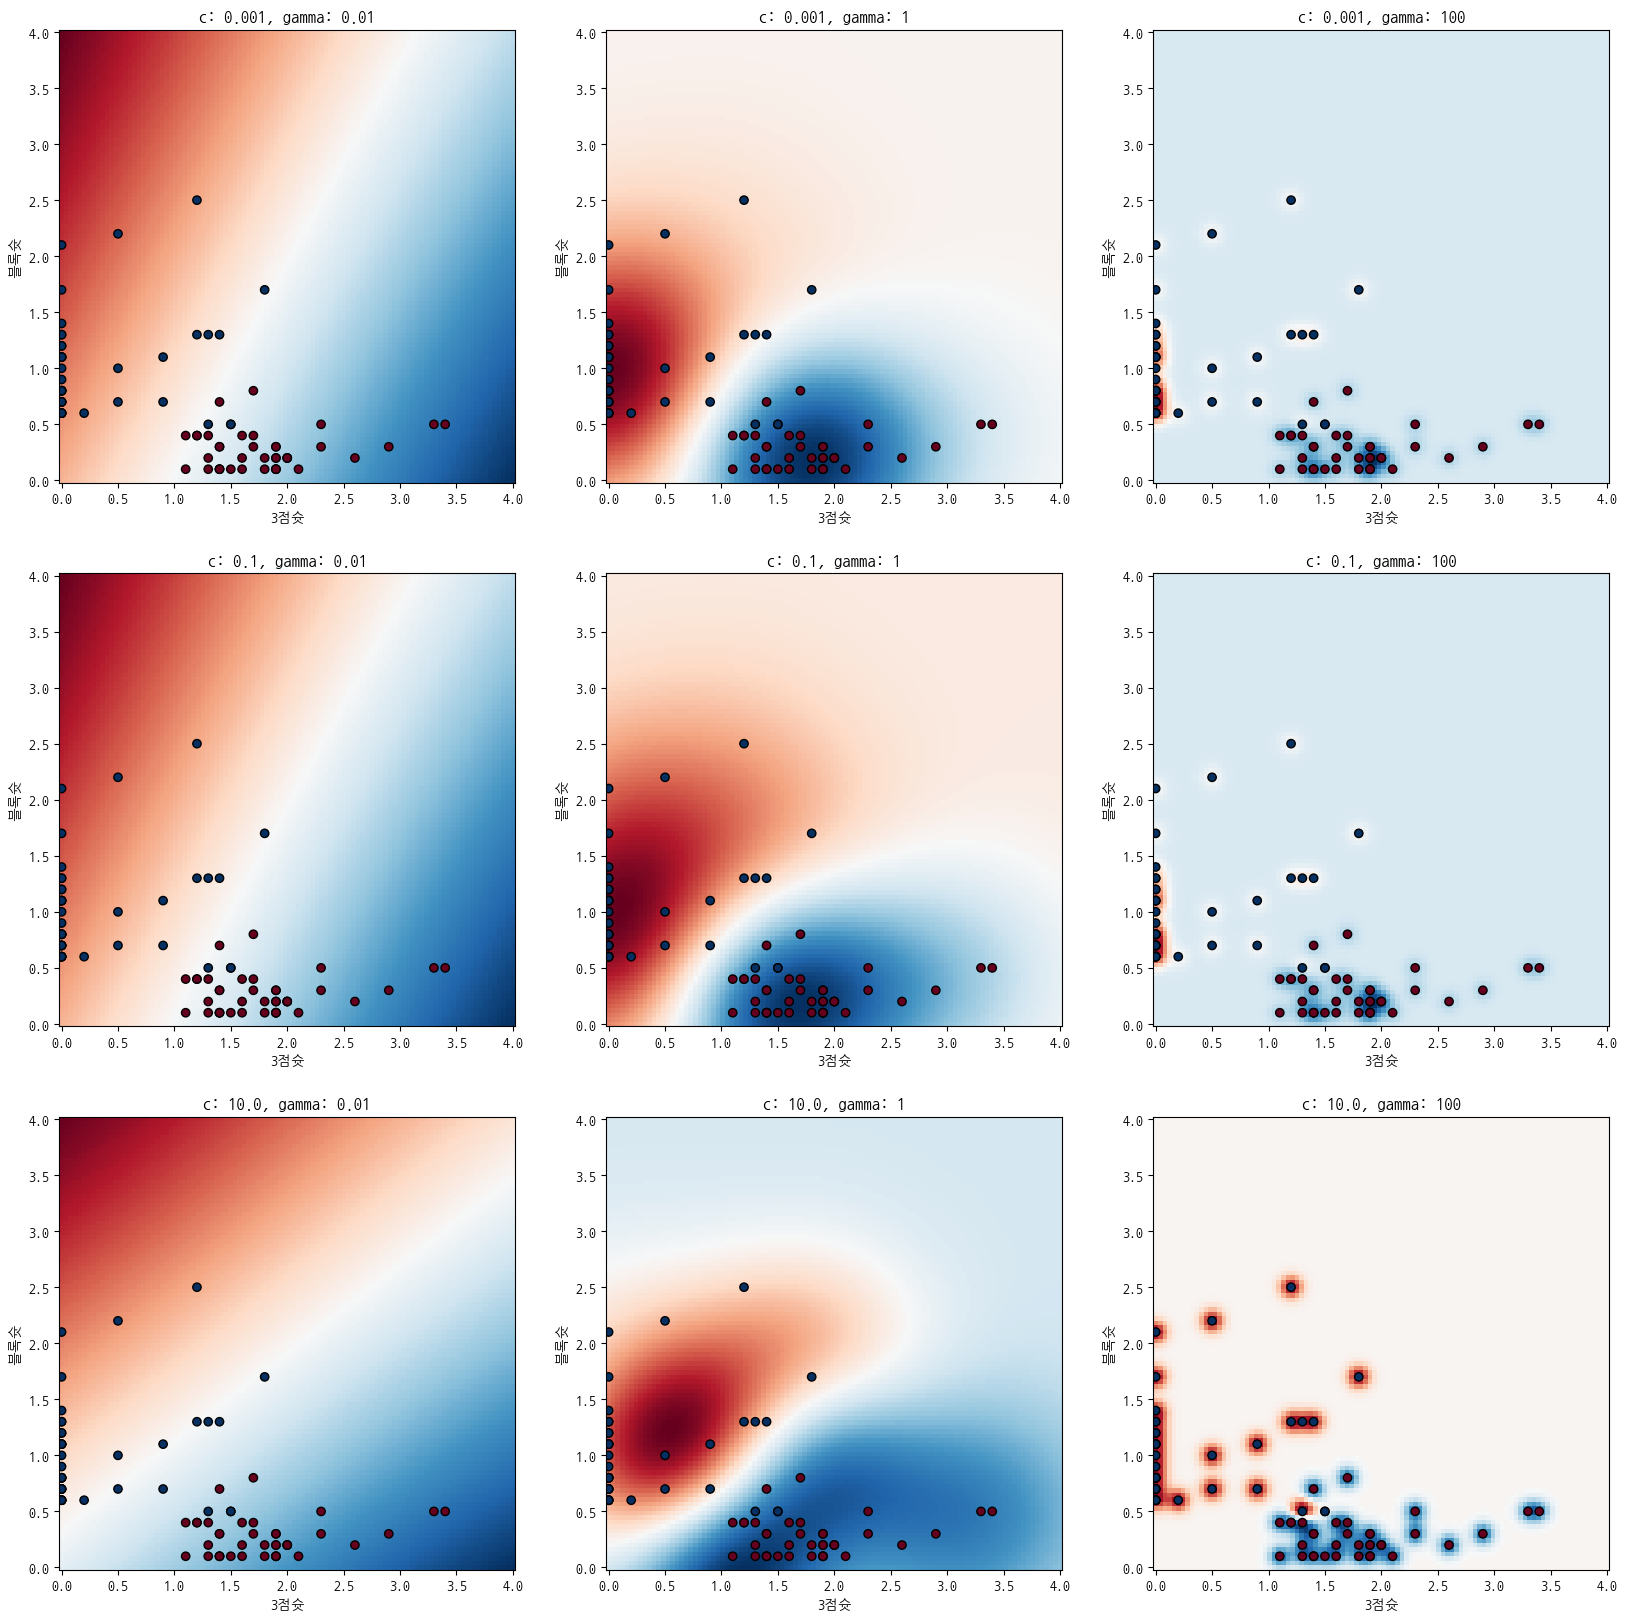

In [10]:
# 최적의 파라미터 후보를 조합해서 완성한 SVM 모델을 시각화 한다.
plt.figure(figsize=(20, 20))
# np.linspace(0, 4, 100): 0 ~ 4를 100 단계로 나눈값을 저장하는 넘파이 배열을 만든다.
# print(np.linspace(0, 4, 100))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100)) # 그래프의 눈금

# enumerate() 함수는 인수로 지정된 리스트의 인덱스와 값을 리턴한다.
for i, (C, gamma, clf) in enumerate(classifiers):
    # print(i, (C, gamma, clf))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # subplot 그래프: 두 개 이상의 그래프의 상관 관계를 효과적으로 비교할 수 있다.
    # subplot 그래프를 만드는 방법은 subplot() 메소드를 사용해서 그래프 위치를 정해주고 그래프를 그리면 된다.
    plt.subplot(len(C_canditates), len(gamma_canditates), i + 1) # subplot 그래프 위치 지정

    # pcolormesh() 메소드로 결정 경계면을 표시한다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu_r)
    
    # 3P를 x축으로 BLK를 y축으로하는 산점도를 그린다.
    plt.scatter(x=x_train['3P'], y=x_train['BLK'], c=position, cmap=plt.cm.RdBu_r, edgecolors='k')
    plt.title('c: {}, gamma: {}'.format(C, gamma))
    plt.xlabel('3점슛')
    plt.ylabel('블록슛')

plt.show()

위 9개의 차트 중 정 가운데 차트가 GridSearchCV 객체를 통해 얻은 최적의 C와 gamma 값을 사용해 학습한 모델이며 균등하게 두 그룹이 분할된 것을 확인할 수 있다.  
위 차트에서 왼쪽에서 오른쪽으로 보면 gamma의 크기에 따른 결정 경계의 곡률 변화를 확인할 수 있고 위에서 아래로 보면 C의 크기에 따른 결정 경계의 위치 변화를 확인할 수 있다.

모델 테스트

In [11]:
x_test = test[['3P', 'BLK']]
y_test = test['Pos']
predict = clf.predict(x_test)
accuracy = accuracy_score(y_test.values.ravel(), predict)
print('정확도: {:6.2%}'.format(accuracy))

정확도: 70.00%


In [12]:
pd.DataFrame({'실제값': y_test.values.ravel(), '예측값': predict})

,실제값,예측값
0,C,C
1,C,SG
2,SG,SG
3,C,C
4,SG,SG
5,C,C
6,C,SG
7,SG,SG
8,SG,SG
9,SG,SG


혼동(confusion) 행렬

In [13]:
# 혼동 행렬을 확인하기 위해 import 한다.
from sklearn.metrics import confusion_matrix
# 분류 리포트(정확도, 정밀도, 재현율, f1 score)를 출력하기 위해 import 한다.
from sklearn.metrics import classification_report

In [14]:
# confusion_matrix() 함수는 인수로 실제값과 예측값을 전달해서 혼동 행렬을 만든다.
print(confusion_matrix(y_test.values.ravel(), predict))

[[5 5]
 [1 9]]


In [15]:
print(classification_report(y_test.values.ravel(), predict))

              precision    recall  f1-score   support

           C       0.83      0.50      0.62        10
          SG       0.64      0.90      0.75        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20

